## The influence of a sub-lithospheric layer width on the partitioning of the induced mantle flow, surface motions and subduction dynamics. Carluccio et al. 2024 (under review)

This notebook generates subducion models in Underworld2. 
The notebook reproduce the main architecture of the models run in the paper. Examples of post-processing analysis notebooks are stored in https://github.com/rcarluccio
/3D-PostProcessing and https://github.com/rcarluccio/MachineLearningApplications



Comparison between the subduction time evolution of the reference model-NO WL (RM) and a model with a WL.

| RM- $\eta_M/\eta_{WL} = 10^{0}$| WL- $\eta_M/\eta_{WL} = 10^{2}$ |
| :---: | :---: | 
| ![alt](testrm.gif) |![alt](test1.gif) |

Case 1: Pseudo-Plastic rheology
-------

This case has a Pseudo-Plastic rheology. Plasticity is impleted near the surface and linear rheology applies deeper in the lithosphere and mantle. 
We assume Byerlee's law which describes the increase in the maximum strength of the upper crustal rocks with increasing confining pressure (depth). 
We also assume an approximation of the Drucker-Prager yield criterion, the so-called depth-dependent (henceforth denoted as DD), which introduces a friction angle and depends only on the lithostatic pressure and neglects the dynamic component. 
The rheology is described by:
    
\begin{equation}
    \eta_{eff} =  
        \begin{cases}
              \eta_0 & \tau < \tau_\textrm{y} \\
              \frac {\tau_\textrm{y}}{2\dot \varepsilon_{II}}  & \textrm{otherwise}
        \end{cases}
\end{equation}

$\tau_{y}$, $\eta_\text{eff}$ and $ \dot \varepsilon_{II} $ are the yield stress, the effective viscosity of the plastic branch and the second invariant of the strain rate tensor, respectively.
    
$\tau_\textrm{y}$ is given by:

\begin{equation}
     \tau_\textrm{y} = \tau_{0}+\mu \text{p}_\text{lith}
\end{equation}


<img src="setup.png">

Scaling based on Newton's second law of motion:
-------
The dimensional analysis is computed accordingly with the Newton second low motion from SI to dimensionless values and viceversa:

    

|Values |Symbol |Scaling Factors | 
| --- | --- | --- | 
|Time | $t_{SF}$ | $\eta_{SF}/\sigma_{SF}$|
|Force |  $F_{SF}$|  $\sigma_{SF}/(l_{SF}^{2})$|
|Acceleration |  $g_{SF}$   | $l_{SF}/t_{SF} /t_{SF}$  |
| Mass |  $m_{SF}$| $F_{SF}/g_{SF}$   |
    


In [1]:
#==========================================================================
# IMPORT LIBRARIES                #
#==========================================================================
import underworld as uw
import math
from underworld import function as fn
import numpy as np
import h5py
import time
import mpi4py
import glucifer

#==========================================================================
# Import library os
#==========================================================================
import os
outputPath = os.path.join(os.path.abspath("."),"m1data/")

if uw.rank()==0:
    if not os.path.exists(outputPath):
        os.makedirs(outputPath)
uw.barrier()
outputPathvelplanes = os.path.join(os.path.abspath("."),"velplanes/")

if uw.rank()==0:
    if not os.path.exists(outputPathvelplanes):
        os.makedirs(outputPathvelplanes)
uw.barrier()

#==========================================================================
# Resolution
#==========================================================================
xRes      =  64
zRes      =  32
yRes      =  32

#==========================================================================
# Initialise time variables/ restart
#==========================================================================
# Inizialise time variables
time         = 157.              # Initial time
step         = 0                 # Initial timestep
maxSteps     = 2 #360     # Maximum timesteps 
steps_output = 1      # output every 10 timesteps
nsteps       = (maxSteps /steps_output)+1   #because i want 0 step

#==========================================================================
# Monitor simulation time
#==========================================================================
comm = mpi4py.MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()
## Start writing log
if rank==0:
    import time as timekeeper
    tStart = timekeeper.time()
    fw = open("Log.txt","w")
    fw.write("%s \n" %(timekeeper.ctime()))
    fw.write("Running on %i proc(s). \n" %size)
    fw.close()
uw.barrier()

In [2]:
#==========================================================================
# Retrive simulation current status and time
#==========================================================================
def getsubProp():
    #'''gets info from slab property file and gives back time, trench, tip and step values''' #
    #if uw.rank()==0:
    
    os.chdir(outputPath)
    file_in  = ('SubductionProp' +'.txt')
    file_in2 = ('SubductionVelProp' +'.txt')
    
    # Initialise new list objects
    istep        = []
    itime        = []
    X_trench     = []
    X_trenchNN   = []
    X_trenchF    = []
    Z_slabTipF   = []
    Z_slabTipB   = []

    
    if os.path.exists(file_in):
        Mode_restart= 'on'
        Prop =np.loadtxt(file_in, skiprows=1)
        
        istep       = list(Prop[:,0])
        itime       = list(Prop[:,1])
        X_trenchF   = list(Prop[:,2])
        X_trench    = list(Prop[:,3])
        X_trenchNN  = list(Prop[:,4])
        Z_slabTipF  = list(Prop[:,5])
        Z_slabTipB  = list(Prop[:,6])
        step, time  = max(istep),max(itime)
        cstep=step
    
    
    else:
        Mode_restart= 'off'
        step, time  = 0.,157.
        #X_trenchF, X_trenchNN, X_trench, Z_slabTipF,Z_slabTipB  = -10.,-10.,-10.,-2.56253,-2.56253
        cstep=step
    #uw.barrier()
    return step, time,istep, itime, X_trenchF,X_trench,X_trenchNN ,Z_slabTipF,Z_slabTipB, Mode_restart,cstep

step,  time, istep, itime, X_trenchF, X_trench, X_trenchNN, Z_slabTipF, Z_slabTipB, Mode_restart,cstep = getsubProp()

nre_step=(maxSteps - step)/steps_output

In [3]:
#==========================================================================
# Characteristics Values          #
#==========================================================================
l_D            =   1.e5        #   [m] 100km
eta_D          =   1.e21       #   [Pa s]
sigma_D        =   1.e10       #   [Pa] 10 GPa ~ 250 km depth
Temperature_D  =   1000       #   [K]


#==========================================================================
# Reference choosen values
#==========================================================================
l_DL            =   1.
eta_DL          =   1.
sigma_DL        =   1.
Temperature_DL  =   1.


#==========================================================================
# Trivial Scaling Factor
#==========================================================================
l_SF            =   l_DL     / l_D
eta_SF          =   eta_DL   / eta_D
sigma_SF        =   sigma_DL / sigma_D
Temperature_SF  =   Temperature_DL / Temperature_D

#==========================================================================
# Basic scaling coefficient LAMEM
#==========================================================================
time_SF         =   eta_SF/sigma_SF
force_SF        =   sigma_SF*(l_SF*l_SF)
g_SF            =   l_SF/time_SF/time_SF
m_SF            =   force_SF/g_SF

#==========================================================================
# Other scaling coefficients
#==========================================================================
angle_SF           = math.pi/180;
area_SF            = l_SF*l_SF
volume_SF          = area_SF*l_SF
energy_SF          = force_SF*l_SF
power_SF           = energy_SF/time_SF
v_SF               = l_SF/time_SF
strain_rate_SF     = 1.0/time_SF
rho_SF             = m_SF/volume_SF

#==========================================================================
# Thermal scaling coefficients
#==========================================================================
Thermal_conductivity_SF         = power_SF/l_SF /Temperature_SF
Thermal_expansion_SF            = 1/Temperature_SF
capacity_SF                     = energy_SF/ Temperature_SF / m_SF
Thermal_diffusivity_SF          = (l_SF*l_SF)  /  time_SF #in uw2

#==========================================================================
# Additional UNITS
#==========================================================================
yr     = 3600.0*24.0*365.25;
Myr    = 1e6*yr;
km     = 1e3;
cm     = 1.e-2;
cm_yr  = cm/yr;
MPa    = 1e6;
mW     = 1e-3;
K      =  273.15
#==========================================================================
# Dimensional physical data
#==========================================================================
DII_ref        =   1e-16
boxWidth       =    3000.0*km
boxHeight      =    660.0*km
boxLength      =    4000.0*km
boxHeight      =    660.0*km
l_max_op       =    1750.0*km
l_min_op       =    - 1000.0*km

Depth_slab     =    - 256.2536*km
l_op           =    - 310.0*km



ThickCrust     =    20.0*km
ThickContCrust =    32.0*km
ThickOP        =    110.0*km
ThickWL        =    60.0*km
ThickControot  =    100.0*km


upperMantleViscosity =    2.5e21
slabViscosity        =    2.5e23
crustViscosity       =    2.5e23
initialViscosity     =    1e22
wlViscosity          =    2.5e20
ovrViscosity         =    2.5e24

mantleDensity  = 3220.0
slabDensity    = 3300.0
crustDensity   = 3300.0
wlDensity      = 3220.0
ovrDensity     = 2700.

Gravity     =  -10
cohesion    =  20 *MPa # Stress is in megaPa with cap S


UpperViscosityCutoff       = 2.5e24
LowerViscosityCutoff       = 2.5e20
#friction_angle = 30 * 1/angle_SF

dt                         = 0.5 *Myr
Temp_top                   = 20 + K     # Temperature @ top
Temp_bottom                = 1463 + K   # Temperature @ bottom; side BC's are flux-free

#==========================================================================
# Getting dimension-less values
#==========================================================================

boxWidth_DL      =  boxWidth * l_SF
boxLength_DL     =  boxLength * l_SF
boxHeight_DL     =  boxHeight * l_SF
l_max_op_DL      =  l_max_op * l_SF
l_min_op_DL      =  l_min_op * l_SF
Depth_slab_DL    =  Depth_slab * l_SF
l_op_DL          =  l_op * l_SF
#l_ovp_DL =l_ovp* l_SF

ThickCrust_DL     =  ThickCrust * l_SF
ThickOP_DL        =  ThickOP * l_SF
ThickWL_DL        =   ThickWL* l_SF
ThickContCrust_DL = ThickContCrust* l_SF
ThickControot_DL  = ThickControot* l_SF

upperMantleViscosity_DL   =    upperMantleViscosity * eta_SF
slabViscosity_DL          =    slabViscosity * eta_SF
crustViscosity_DL         =    crustViscosity * eta_SF
wlViscosity_DL            =    wlViscosity * eta_SF
ovpViscosity_DL = ovrViscosity * eta_SF

mantleDensity_DL          =  mantleDensity * rho_SF
slabDensity_DL            =  slabDensity * rho_SF
crustDensity_DL           =  crustDensity * rho_SF
wlDensity_DL              =  wlDensity * rho_SF
ovpDensity_DL             = ovrDensity * rho_SF

DII_ref_DL1               = DII_ref * (1.0/time_SF )
g_DL                      = Gravity* g_SF
cohesion_DL               = cohesion * sigma_SF

dt_DL                     = dt*time_SF
Temp_top_DL               = Temp_top * Temperature_SF
Temp_bottom_DL            = Temp_bottom* Temperature_SF

initialViscosity_DL       = initialViscosity * eta_SF
LowerViscosityCutoff_DL   = LowerViscosityCutoff * eta_SF
UpperViscosityCutoff_DL   = UpperViscosityCutoff* eta_SF

DII_ref_DL                = DII_ref * strain_rate_SF


In [4]:
#==========================================================================
# DOMAIN PARAMETERS (non-DIMENSIONAL)
#==========================================================================
dim       =  3

L         =  boxLength_DL
W         =  boxWidth_DL
H         =  boxHeight_DL

dx         =   boxLength_DL/xRes
dz         =   boxHeight_DL/zRes
dy         =   W/yRes
dy         =     W/yRes

y_back     =    -W/2;                #  coord of the front margin
w_min_op   =    -W               # attached to the front wall
w_max_wl   =    -W/2 + W/2;
w_max_slab =    -y_back
x_left     =   -L/2                 #  coord of the left margin
z_bot      =   -H                   #  coord of the bottom margin
z_surface  =   -H+H
modelTime = str("{0:.5f}").format(float(time)/ time_SF/ Myr/10000 )

gridpoints_x = xRes+1
gridpoints_z = zRes+1
gridpoints_y = yRes+1
gridpoints_xy=gridpoints_x*gridpoints_y
gridpoints_xz=gridpoints_x*gridpoints_z
#==========================================================================
# INITIALIZE MESH AND MESH VARIABLES
#==========================================================================
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"),
                                elementRes  = (xRes, yRes, zRes),
                                minCoord    = (x_left , z_bot, y_back),
                                maxCoord    = (-x_left, z_surface, -y_back) )

velocityField       = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=dim )
pressureField       = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )
temperatureField    = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=1 )

#==========================================================================
# Set initial conditions
#==========================================================================
velocityField.data[:] = [0.,0.,0.]
pressureField.data[:] = 0.
#help(fn.view.min_max)

#==========================================================================
# Boundary conditions
#==========================================================================
iWalls      = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls      = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
kWalls      = mesh.specialSets["MinK_VertexSet"] + mesh.specialSets["MaxK_VertexSet"]
bottomWall  = mesh.specialSets["MinJ_VertexSet"]
topWall      = mesh.specialSets["MaxJ_VertexSet"]
allWalls    = iWalls + jWalls
#periodicBC = uw.conditions.DirichletCondition( variable        = velocityField,
#indexSetsPerDof = ( bottomWall, jWalls) )

freeslipBC = uw.conditions.DirichletCondition( variable      = velocityField,
                                              indexSetsPerDof = (iWalls, jWalls,kWalls) )

In [5]:
#==========================================================================
# Setup global material swarm
#==========================================================================
# Global swarm
swarm               = uw.swarm.Swarm( mesh=mesh )
materialVariable    = swarm.add_variable( dataType="int", count=1 )

# create pop control object
pop_control         = uw.swarm.PopulationControl(swarm,aggressive=True,particlesPerCell=50)
#==========================================================================
# Define phase thickness no half space
#==========================================================================
z_UC0               =   - ThickCrust_DL
z_UC1               =   z_UC0 - ThickOP_DL
z_UC3               =   z_UC0 - ThickOP_DL-ThickWL_DL
z_UC4               =   - ThickContCrust_DL
z_UC5               =   - ThickContCrust_DL - ThickControot_DL

In [6]:
#==========================================================================
# Allocate materials to particles
#==========================================================================
# initialise the 'materialVariable' data to represent two different materials.
UC0             =   0
UC1             =   1            # oceanic plate
UC2             =   3            # mantle
UC3             =   2            # wl

coordinateFn=fn.coord()
sectionFn = ((coordinateFn[2]<w_max_slab ))

# crust
RectOcCrustcoord =  np.array([ ((l_max_op_DL-0.28) ,z_surface ), (l_min_op_DL ,z_surface ),   (l_min_op_DL ,z_UC0), ((l_max_op_DL-0.28) ,z_UC0) ])
alpha            =  -34*math.pi/180
R                =  np.array([ [(math.cos(alpha)), (math.sin(alpha))],[-(math.sin(alpha)), (math.cos(alpha))] ])
coordcrust       =  np.array([ [(l_op_DL),(0.), (0.), (l_op_DL)], [(0.),(0.),(z_UC0),(z_UC0)] ])
c_coord          =  np.dot(R,coordcrust)
c_coordX         =  c_coord[0, :] + l_min_op_DL
c_coordZ         =  c_coord[1, :]
c_coords         =  np.zeros((4,2))
c_coords[:,0]    =  c_coordX
c_coords[:,1]    =  c_coordZ
crustrec         =  fn.shape.Polygon( RectOcCrustcoord )
crustrec3d       =  sectionFn & crustrec
crustdip         =  fn.shape.Polygon( c_coords )
crustdip3d       =  sectionFn & crustdip

# crust tail
coordCrustTail  =   np.array([ ((l_max_op_DL-0.28) ,z_surface), (l_max_op_DL,z_surface),((l_max_op_DL-0.28),z_UC0 ) ])
crTail          =   fn.shape.Polygon( coordCrustTail  )
crTail3d        =   sectionFn and crTail

sectionFn = ((coordinateFn[2]<w_max_slab ))
# slab
RectOcPlateCoord = np.array([ ((l_max_op_DL-1.41) , z_UC0), (l_min_op_DL,z_UC0 ),     (l_min_op_DL,z_UC1), ((l_max_op_DL-1.41),z_UC1) ])
coordslab        =  np.array([ [(l_op_DL),(0.), (0.), (l_op_DL)], [(z_UC0),(z_UC0),(z_UC1),(z_UC1)] ])
s_coord          =  np.dot(R,coordslab)
s_coordX         =  s_coord[0, :] + l_min_op_DL
s_coordZ         =  s_coord[1, :]
s_coords         =  np.zeros((4,2))
s_coords[:,0]    =  s_coordX
s_coords[:,1]    =  s_coordZ
slabrec          =  fn.shape.Polygon( RectOcPlateCoord  )
slabdip          =  fn.shape.Polygon( s_coords  )
slabdip3d        =  sectionFn and slabdip
slabrec3d        =  sectionFn and slabrec

# PlateTail
coordPlateTail       =   np.array([ ((l_max_op_DL-1.41) ,z_UC0), (l_max_op_DL,z_UC0),((l_max_op_DL-1.41),z_UC1 ) ])
ptTail               = fn.shape.Polygon( coordPlateTail  )
ptTail3d             = sectionFn and ptTail


sectionFn            = ((coordinateFn[2]<w_max_wl ))
# wl
RectWLCoord       =  np.array([ ((l_max_op_DL-1.83) ,z_UC1), (l_min_op_DL,z_UC1 ),(l_min_op_DL,z_UC3), ((l_max_op_DL-1.83),z_UC3) ])
coordwl           =  np.array([ [(l_op_DL),(0.), (0.), (l_op_DL)], [(z_UC1),(z_UC1),(z_UC3),(z_UC3)] ])
wl_coord          =  np.dot(R,coordwl)
wl_coordX         =  wl_coord[0, :] + l_min_op_DL
wl_coordZ         =  wl_coord[1, :]
wl_coords         =  np.zeros((4,2))
wl_coords[:,0]    =  wl_coordX
wl_coords[:,1]    =  wl_coordZ
wlrec             = fn.shape.Polygon( RectWLCoord  )
wldip             = fn.shape.Polygon( wl_coords  )
wlrec3d             = sectionFn and wlrec
wldip3d             = sectionFn and wldip

coordWlTail         =   np.array([ ((l_max_op_DL-1.83) ,z_UC1), ((l_max_op_DL),z_UC1),((l_max_op_DL-1.83),z_UC3 ) ])
wlTail              = fn.shape.Polygon( coordWlTail )
wlTail3d            = sectionFn and wlTail



if step == 0:
    swarmLayout         = uw.swarm.layouts.GlobalSpaceFillerLayout( swarm=swarm, particlesPerCell=20 )
    swarm.populate_using_layout( layout=swarmLayout )

    # initialise everying to be upper mantle material
    materialVariable.data[:] = UC2

    # Change matieral index if the particle is not upper mantle
    for index in range( len(swarm.particleCoordinates.data) ):
        coord = swarm.particleCoordinates.data[index][:]
        if wldip3d.evaluate(tuple(coord)):
            materialVariable.data[index] = UC3
        if wlTail3d.evaluate(tuple(coord)):
            materialVariable.data[index] = UC3
        if wlrec3d.evaluate(tuple(coord)):
            materialVariable.data[index] = UC3


        if crustdip3d.evaluate(tuple(coord)):
            materialVariable.data[index] = UC0
        if crustrec3d.evaluate(tuple(coord)):
            materialVariable.data[index] = UC0
        if crTail3d.evaluate(tuple(coord)):
            materialVariable.data[index] = UC0
        if slabdip3d.evaluate(tuple(coord)):
            materialVariable.data[index] = UC1
        if slabrec3d.evaluate(tuple(coord)):
            materialVariable.data[index] = UC1
        if ptTail3d.evaluate(tuple(coord)):
            materialVariable.data[index] = UC1


    if(uw.rank()==0):
        np.savetxt( outputPath + 'PhysicsPro.txt', np.c_[upperMantleViscosity, slabViscosity, wlViscosity, mantleDensity, slabDensity, wlDensity, ThickOP, ThickWL],
                   header="MantleViscosity, slabViscosity, wlViscosity, mantleDensity,slabDensity, wlDensity, ThickOP, ThickWL" )



else:

    modelTime = str("{0:.5f}").format(float(time)/ time_SF/ Myr/10000 )
    mesh.load(      outputPath + "meshData-"  + modelTime+ ".h5")
    velocityField.load( outputPath +  "vel-"+ modelTime+ ".h5")
    pressureField.load(outputPath +  "pressure-"+ modelTime+ ".h5")
    swarm.load(outputPath + "swarmData-"  + modelTime+ ".h5")
    materialVariable.load(    outputPath + "materialVariable-"+ modelTime+ ".h5")

In [7]:
#==========================================================================
# Setup surface material swarm-trench edge fixed on x tracking
#==========================================================================
# Surface swarm
surfaceSwarmfront        = uw.swarm.Swarm( mesh=mesh )
materialVarfront         = surfaceSwarmfront.add_variable( dataType="int", count=1 )
if step ==0:
    # passive markers at the surface
    surfacePointsfront        = np.zeros((1000,3))
    surfacePointsfront[:,0]   = np.linspace(l_min_op_DL, l_max_op_DL, 1000)
    surfacePointsfront[:,1]   = z_surface
    surfacePointsfront[:,2]   = w_max_slab
  
    
    surfaceSwarmfront.add_particles_with_coordinates( surfacePointsfront )
    
    pass
    
    # initialise everying to be None
    #materialVar.data[:] = 999
    
    # Change matieral index if the particle is not upper mantle
    
    for index in range( len(surfaceSwarmfront.particleCoordinates.data) ):
        coord = surfaceSwarmfront.particleCoordinates.data[index][:]
        
        if crustdip3d.evaluate(tuple(coord)):
            materialVarfront.data[index] = UC0
        if crustrec3d.evaluate(tuple(coord)):
            materialVarfront.data[index] = UC0
        if crTail3d.evaluate(tuple(coord)):
            materialVarfront.data[index] = UC0


else:
    
    surfaceSwarmfront.load(outputPath + "surfaceSwarm_front-"  + modelTime+ ".h5")
    materialVarfront.load(    outputPath + "materialVar_front-"+ modelTime+ ".h5")
#==========================================================================
# Setup surface material swarm-trench edge NON-fixed on x tracking maybe relevant for vorticity?? diffential in trench migration fixed and not
#==========================================================================
# Surface swarm
surfaceSwarmmid        = uw.swarm.Swarm( mesh=mesh )
materialVarmid         = surfaceSwarmmid.add_variable( dataType="int", count=1 )

if step ==0:
    # passive markers at the surface
    surfacePointsmid        = np.zeros((1000,3))
    surfacePointsmid[:,0]   = np.linspace(l_min_op_DL, l_max_op_DL, 1000)
    surfacePointsmid[:,1]   = z_surface
    surfacePointsmid[:,2]   = w_max_wl
   
    
    surfaceSwarmmid.add_particles_with_coordinates( surfacePointsmid )
    
    pass
    
    # initialise everying to be None
    #materialVar.data[:] = 999
    
    # Change matieral index if the particle is not upper mantle
    
    for index in range( len(surfaceSwarmmid.particleCoordinates.data) ):
        coord = surfaceSwarmmid.particleCoordinates.data[index][:]
        if coord[2] >w_max_slab:
            if crustdip3d.evaluate(tuple(coord)):
                materialVarmid.data[index] = UC0
            if crustrec3d.evaluate(tuple(coord)):
                materialVarmid.data[index] = UC0
            if crTail3d.evaluate(tuple(coord)):
                    materialVarmid.data[index] = UC0

else:
    surfaceSwarmmid.load(outputPath + "surfaceSwarm_mid-"  + modelTime+ ".h5")
    materialVarmid.load(    outputPath + "materialVar_mid-"+ modelTime+ ".h5")

#==========================================================================
# Setup surface material back plate
#==========================================================================
# Surface swarm
surfaceSwarmback        = uw.swarm.Swarm( mesh=mesh )
materialVarback         = surfaceSwarmback.add_variable( dataType="int", count=1 )
w_min_op= -15.          #for some reason doesnt iterate the y_back or previous w_min_op maybe because comes from python calculations
if step ==0:
    # passive markers at the surface
    surfacePointsback        = np.zeros((1000,3))
    surfacePointsback[:,0]   = np.linspace(l_min_op_DL, l_max_op_DL, 1000)
    surfacePointsback[:,1]   = z_surface
    #surfacePointsback[:,2]   = -15.    #w_min_op
    surfacePointsback[:,2]   = w_min_op
    
    
    surfaceSwarmback.add_particles_with_coordinates( surfacePointsback )
    
    pass
    
    # initialise everying to be None
    #materialVar.data[:] = 999
    
    # Change matieral index if the particle is not upper mantle
    
    for index in range( len(surfaceSwarmback.particleCoordinates.data) ):
        coord = surfaceSwarmback.particleCoordinates.data[index][:]
        if crustdip3d.evaluate(tuple(coord)):
            materialVarback.data[index] = UC0
        if crustrec3d.evaluate(tuple(coord)):
            materialVarback.data[index] = UC0
        if crTail3d.evaluate(tuple(coord)):
            materialVarback.data[index] = UC0

else:
    surfaceSwarmback.load(outputPath + "surfaceSwarm_back-"  + modelTime+ ".h5")
    materialVarback.load( outputPath + "materialVar_back-"+ modelTime+ ".h5")


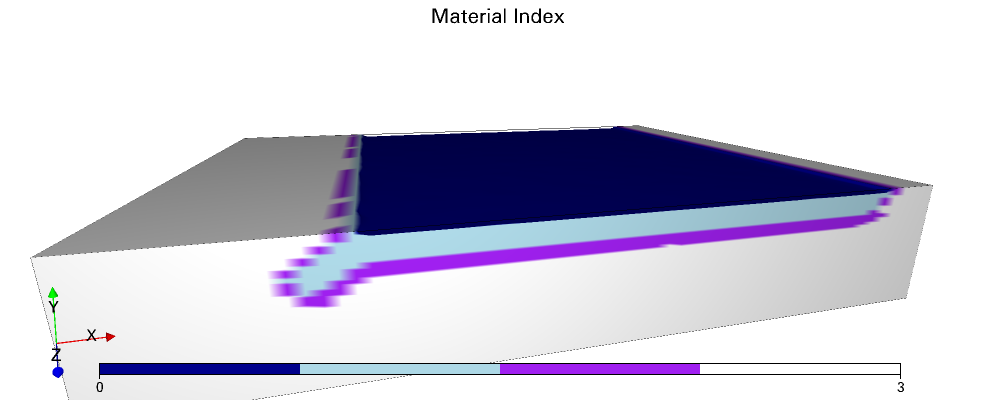

In [8]:
#First project material index on to mesh for use in plotting material isosurfaces
materialField     = uw.mesh.MeshVariable( mesh, 1 )
materialProjector = uw.utils.MeshVariable_Projection(  materialField,materialVariable, type=0 )
materialProjector.solve()

# plot isosurface for materialField values = 0.5
figMaterialLayout = glucifer.Figure( figsize=(1000,400), quality=2, title='Material Index', axis=True)
figMaterialLayout.append(glucifer.objects.IsoSurface( mesh, materialField, isovalues=[0.5], 
                                                     isowalls=True, shift=1, pointSize=1,     colours='darkblue lightblue purple white', discrete=True ))

camera = ['rotate y 15', 'rotate x 15']
figMaterialLayout.script(camera)
figMaterialLayout.show()

In [9]:
#==========================================================================
# Create a particle advection system
#==========================================================================
advector            = uw.systems.SwarmAdvector( swarm=swarm,                           velocityField=velocityField, order=2 )
advector2           = uw.systems.SwarmAdvector( swarm=surfaceSwarmfront,               velocityField=velocityField, order=2 )
advector3           = uw.systems.SwarmAdvector( swarm=surfaceSwarmmid,                 velocityField=velocityField, order=2 )
advector4           = uw.systems.SwarmAdvector( swarm=surfaceSwarmback,                velocityField=velocityField, order=2 )

#==========================================================================
# Mapping density
#==========================================================================
densityMap = {  UC3 :   wlDensity_DL,
                UC2 :   mantleDensity_DL,
                UC1 :   slabDensity_DL,
                UC0 :   crustDensity_DL}

densityFn = fn.branching.map( fn_key = materialVariable, mapping = densityMap )

# Define our vertical unit vector using a python tuple
z_hat           =   ( 0.0, H , 0.0)

# now create a buoyancy force vector
buoyancyFn      =   g_DL * densityFn * z_hat

# Get the lithostatic pressure term out
coordinateFn    =   fn.coord()
Zcoord          =   coordinateFn[1]
P_lithp         =   (g_DL * densityFn * (Zcoord))


In [10]:
#==========================================================================
# Implementing Plasticity for the crust
#==========================================================================
friction_angle_DL         =  math.tan((30.0*math.pi)/180)
yieldStressFn             =  cohesion_DL + (friction_angle_DL * P_lithp)
strainRate_2ndInvariantFn =  fn.tensor.second_invariant(
                                                        fn.tensor.symmetric(
                                                                            velocityField.fn_gradient ))

strainRateFn              =  fn.tensor.symmetric( velocityField.fn_gradient )
eta_Pl                    =  0.5 * yieldStressFn / (strainRate_2ndInvariantFn+DII_ref_DL )              #real DII_ref 1.0e-16

Crust_Eff_viscosity      = LowerViscosityCutoff_DL +fn.exception.SafeMaths( fn.misc.min(eta_Pl,crustViscosity_DL) )

In [11]:
#==========================================================================
# Mapping viscosity
#==========================================================================
viscosityMap    =   {   UC3     :   wlViscosity_DL,
                        UC2     :   upperMantleViscosity_DL,
                        UC1     :   slabViscosity_DL,
                        UC0     :   Crust_Eff_viscosity  }

viscosityMapFn           = fn.branching.map( fn_key = materialVariable, mapping = viscosityMap )
devStress_2ndInvariantFn  = 2.0 * viscosityMapFn * strainRate_2ndInvariantFn

In [12]:

#==========================================================================
# Initialise variable to update the pressure field
#==========================================================================
surfaceArea = uw.utils.Integral(fn=1.0,mesh=mesh, integrationType='surface', surfaceIndexSet=topWall)
surfacePressureIntegral = uw.utils.Integral(fn=pressureField, mesh=mesh, integrationType='surface', surfaceIndexSet=topWall)

(areap,) = surfaceArea.evaluate()
(p0,) = surfacePressureIntegral.evaluate()

pressureField.data[:] -= p0 / areap

# The root mean square Velocity
velSquared = uw.utils.Integral( fn.math.dot(velocityField,velocityField), mesh )
area       = uw.utils.Integral( 1., mesh )
Vrms       = math.sqrt( velSquared.evaluate()[0]/area.evaluate()[0] )

#===================================================================
# Solver options
#==========================================================================
# Initial linear slab viscosity setup

stokes = uw.systems.Stokes(    velocityField = velocityField,
                           pressureField = pressureField,
                           voronoi_swarm = swarm,
                           conditions    = freeslipBC,
                           fn_viscosity  = viscosityMapFn,
                           fn_bodyforce  = buoyancyFn )
# Create solver & solve
solver = uw.systems.Solver(stokes)
solver.options.scr.ksp_rtol = 1.0e-4

# use "lu" direct solve if running in serial
solver.solve( nonLinearIterate=True ,nonLinearTolerance=0.01, nonLinearMaxIterations=15, )

In [13]:
#==========================================================================
# Define an update function
#==========================================================================
def update():
    
    # Retrieve the maximum possible timestep for the advection system.
    dt = advector.get_max_dt()
    advector.integrate(dt)
    advector2.integrate(dt)
    advector3.integrate(dt)
    advector4.integrate(dt)
    
    # particle population control #
    pop_control.repopulate()
    
    return time+dt, step+1


In [14]:
#==========================================================================
# Checkpoints
#==========================================================================
SI_UNITS                        = 'on'
# my mesh is regular
Matmesh                         = uw.mesh.MeshVariable( mesh, 1 )
def checkpoint():
    
    # swarm variables   
    swarm.save(                   outputPath + "swarmData-"  + modelTime+ ".h5")
  
    surfaceSwarmfront.save( outputPath + "surfaceSwarm_front-"  + modelTime+ ".h5")
    surfaceSwarmmid.save( outputPath + "surfaceSwarm_mid-"  + modelTime+ ".h5")
    surfaceSwarmback.save( outputPath + "surfaceSwarm_back-"  + modelTime+ ".h5")
    
    materialVariable.save(    outputPath + "materialVariable-"+ modelTime+ ".h5")
    materialVarmid.save(    outputPath + "materialVar_mid-"+ modelTime+ ".h5")
    materialVarfront.save(    outputPath + "materialVar_front-"+ modelTime+ ".h5")
    materialVarback.save(    outputPath + "materialVar_back-"+ modelTime+ ".h5")
    
    
    materialVariable.save(        outputPath + "materialVariable-"+ modelTime+ ".h5")
    #materialVar.save(             outputPath + "materialVar-"+ modelTime+ ".h5")
    
    mh                          = mesh.save(      outputPath + "meshData-"  + modelTime+ ".h5")
    
    preFilename                 = outputPath + 'pressure-' + modelTime + '.xdmf'
    preHnd                      = pressureField.save(outputPath + 'pressure-' + modelTime +'.h5',
                                     mh)
                                     
                                
    velFilename                 = outputPath + 'vel-' + modelTime + '.xdmf'
    velHnd                      = velocityField.save(outputPath + 'vel-' + modelTime +'.h5',
                                                     mh)
   
    if SI_UNITS =='on':
    # Plot dimensional values
        # Plot Phase field
        projectorMat                    = uw.utils.MeshVariable_Projection( Matmesh,materialVariable , type=0 )
        projectorMat.solve()
        MatFilename                     = outputPath + 'projectorMat-' + modelTime + '.xdmf'
        MatHnd                          = Matmesh.save(outputPath + 'projectorMat-' + modelTime +'.h5',
                             mh)
        Matmesh.xdmf(MatFilename,  MatHnd, "Phase", mh , 'Mesh', modeltime=float(time))
        

         
        # Plot PASSIVE SWARMS IN PARAVIEW
        swarmfrontHndsurf       =   surfaceSwarmfront.save( outputPath + "surfaceSwarm_front-"  + modelTime+ ".h5")
        swarmmidHndsurf         =   surfaceSwarmmid.save( outputPath + "surfaceSwarm_mid-"  + modelTime+ ".h5")
        swarmbackHndsurf        =   surfaceSwarmback.save( outputPath + "surfaceSwarm_back-"  + modelTime+ ".h5")

        materialVarmidHndsurf   =   materialVarmid.save(    outputPath + "materialVar_mid-"+ modelTime+ ".h5")
        materialVarfrontHndsurf =   materialVarfront.save(    outputPath + "materialVar_front-"+ modelTime+ ".h5")
        materialVarbackHndsurf  =   materialVarback.save(    outputPath + "materialVar_back-"+ modelTime+ ".h5")


        materialVarmid.xdmf(outputPath+"materialVar_mid-"+ modelTime+ '.xdmf',
                     materialVarmidHndsurf,"materialVar_mid--",swarmmidHndsurf,"surfaceSwarm_mid-",modeltime=time)

        materialVarback.xdmf(outputPath+"materialVar_back-"+ modelTime+ '.xdmf',
                      materialVarbackHndsurf,"materialVar_back-",swarmbackHndsurf,"surfaceSwarm_back-",modeltime=time)

        materialVarfront.xdmf(outputPath+"materialVar_front-"+ modelTime+ '.xdmf',
                       materialVarfrontHndsurf,"materialVar_front-",swarmfrontHndsurf,"surfaceSwarm_front-",modeltime=time)
        
        ##### get field in Dim values ###
        velocityField.data[:]           = velocityField.data[:]/v_SF   * (yr/cm)
        velFilename_D                   = outputPath + 'vel_D-' + modelTime + '.xdmf'
        velHnd_D                        = velocityField.save(outputPath + 'vel_D-' + modelTime +'.h5',
                                        mh)
        velocityField.xdmf(               velFilename_D, velHnd_D, "Vel [cm/yr]", mh, 'TheMesh', modeltime=float(time))
        velocityField.data[:]           = velocityField.data[:]*v_SF   / (yr/cm)
                                    
        #Dim Pressure
        pressureField.data[:]           = pressureField.data[:]/sigma_SF  /(MPa)
        preFilenameD                    = outputPath + 'pressureD-' + modelTime + '.xdmf'
        preHndD                         = pressureField.save(outputPath + 'pressureD-' + modelTime +'.h5',
                                                                mh)
        pressureField.xdmf(               preFilenameD, preHndD, "Pressure [MPa]", mh, 'TheMesh', modeltime=float(time))
        pressureField.data[:]           = pressureField.data[:]*sigma_SF  *MPa
                                    
                                    
        # plot viscosity
        projectorViscosityD             = uw.utils.MeshVariable_Projection( Matmesh,viscosityMapFn/eta_SF, type=0 )
        projectorViscosityD.solve()
        VisFilenameD                    = outputPath + 'ProjViscosityD-' + modelTime + '.xdmf'
        ViscHndD                        = Matmesh.save(outputPath + 'ProjViscosityD-' + modelTime +'.h5',
                                       mh)
        Matmesh.xdmf(                     VisFilenameD,  ViscHndD, "Effeta [Pa s]", mh , 'Mesh', modeltime=float(time))
        
          
        # plot Log viscosity
        etafn= viscosityMapFn/eta_SF
        
        etaLog = fn.math.log10( etafn)
        
        projectorLogViscosityD             = uw.utils.MeshVariable_Projection( Matmesh, etaLog, type=0 )
        projectorLogViscosityD.solve()
        VisLogFilenameD                    = outputPath + 'ProjLogViscosityD-' + modelTime + '.xdmf'
        ViscLogHndD                        = Matmesh.save(outputPath + 'ProjLogViscosityD-' + modelTime +'.h5',
                                                          mh)
        Matmesh.xdmf(                     VisLogFilenameD,  ViscLogHndD, "Log_Effeta[Pa s]", mh , 'Mesh', modeltime=float(time))
                                                          
        # plot density
        projectorDensityD   = uw.utils.MeshVariable_Projection( Matmesh,(densityFn/rho_SF), type=0 )
        projectorDensityD.solve()

        rhoFilenameD        = outputPath + 'ProjDensityD-' + modelTime + '.xdmf'
        rhoHndD             = Matmesh.save(outputPath + 'ProjDensityD-' + modelTime +'.h5',
                                       mh)

        Matmesh.xdmf(rhoFilenameD,  rhoHndD, "Eff_rho [kg m-3]", mh , 'Mesh', modeltime=float(time))

        

In [15]:
#==========================================================================
# Retrieving Vel Field info for post-processing
#==========================================================================
def get_Mean_Plate_Slab_Vel():
    coord                                       =       fn.coord()  # creates a function which returns the coordinate
    coordx                                      =       coord[0]  # gets the x part of the coordinate
    coordy                                      =       coord[2]  # gets the z part of the coordinate
    coordz                                      =       coord[1]  # gets the z part of the coordinate

    fn_conditional_tip                          =       fn.branching.conditional( [ (materialVariable < UC1+0.1, swarm.particleCoordinates[1] ),
                                                                                   (                  True, 99999999. ) ] )
    masktipcoords                               =       ((coordy <- y_back) & (coordy <- y_back-0.1))
    fn_conditional_tip_front                    =       fn_conditional_tip*masktipcoords
    testslabMM                                  =       fn.view.min_max(fn_conditional_tip)
    dummy_tip                                   =       testslabMM.evaluate(swarm)
    slab_tip_front                              =       testslabMM.min_global()


    masktipcoords_back                          =       ((coordy > y_back) & (coordy < y_back+0.2))
    fn_conditional_tip_back                     =       fn_conditional_tip*masktipcoords_back
    testslabMM                                  =       fn.view.min_max(fn_conditional_tip)
    dummy_tip                                   =       testslabMM.evaluate(swarm)
    slab_tip_back                               =       testslabMM.min_global()


    fn_conditional                              =       fn.branching.conditional( [ (materialVarmid < UC0+1.0, surfaceSwarmmid.particleCoordinates[0]),
                                                                                   (                  True, 99999999. ) ] )
    testMMN_mid                                 =       fn.view.min_max(fn_conditional)
    dummy_mid                                   =       testMMN_mid.evaluate(surfaceSwarmmid)
    x_trench_mid                                =       testMMN_mid.min_global()


    fn_conditional                              =       fn.branching.conditional( [ (materialVarback < UC0+1.0, surfaceSwarmback.particleCoordinates[0]),
                                                                                   (                  True, 99999999. ) ] )
    testMM_back                                 =       fn.view.min_max(fn_conditional)
    dummy_back                                  =       testMM_back.evaluate(surfaceSwarmback )
    x_trench_back                               =       testMM_back.min_global()


    # Xcoords and Zcoords condition - mask 2
    fn_conditional                              =       fn.branching.conditional( [ (materialVarfront < UC0+1., surfaceSwarmfront.particleCoordinates[0]),
                                                                                   (                  True, 99999999. ) ] )
    Crust_Xmin_Xmax                             =       fn.view.min_max(fn_conditional)
    dummy_Front                                 =       Crust_Xmin_Xmax.evaluate(surfaceSwarmfront)
    Crust_Xmin_trench                           =       Crust_Xmin_Xmax.min_global()



                                                                                       
    return slab_tip_front ,slab_tip_back,Crust_Xmin_trench, x_trench_mid, x_trench_back 

In [16]:
#==========================================================================
# Stokes solver
#==========================================================================
#sT = time.x()
if rank==0:
    fw = open("Log.txt","a")
    fw.write("Set-up time: %.2f seconds\n" %(timekeeper.time() - tStart))
    fw.write("--------------------- \n")
    fw.write("Time \t Step \t Stopwatch\n")
    tPreviousStep = timekeeper.time()
    t0 = tPreviousStep
    print tStart
    fw.close()

# Main time solver loop
while step <= maxSteps:

    # Solve non linear Stokes system
    solver.solve(nonLinearIterate=True,nonLinearTolerance=0.01)
    solver.print_stats()
    #solver.options.main.help=' -log_view ascii:stokesupodated.log -memory_view'
    
    # Calibrate the pressure Field -Obtain V,P and remove null-space / drift in pressure
    (areap,)                = surfaceArea.evaluate()
    (p0,)                   = surfacePressureIntegral.evaluate()
    pressureField.data[:]  -= p0 / areap
    if rank==0:
        fw = open("Log.txt","a")
        fw.write("%.2f \t %i \t %.2f \n" %(time,step,timekeeper.time() - tPreviousStep))
        tPreviousStep = timekeeper.time()
        fw.close()
    
    if Mode_restart == 'off':
        # output figure to file at intervals = steps_output
        if step in np.linspace (0,maxSteps,nsteps) :
            slab_tip_front ,slab_tip_back,Crust_Xmin_trench, x_trench_mid, x_trench_back =get_Mean_Plate_Slab_Vel()
            
           
        
            X_trenchF.append(Crust_Xmin_trench)
            X_trench.append(x_trench_mid)
            X_trenchNN.append(x_trench_back)
            
            Z_slabTipF.append(slab_tip_front)
            Z_slabTipB.append(slab_tip_back)

            itime.append(time)
            istep.append(step)
            

            Vrms           =    math.sqrt( velSquared.evaluate()[0]/area.evaluate()[0] )
            modelTime = str("{0:.5f}").format(float(time)/ time_SF/ Myr/10000 )
            
        # Saver subduction properties files here to avoid lost with restart
            if(uw.rank()==0):
                print 'Mode_restart = off'
                print 'step = {0:6d}; time = {1:.3e}, Vrms = {2:.3e}'.format(int(step), float(time),Vrms)
                
                
                np.savetxt( outputPath + 'SubductionProp.txt', np.c_[istep,  itime, X_trenchF, X_trench, X_trenchNN, Z_slabTipF, Z_slabTipB],
                           header="Steps, Time, x_trenchFront, x_trench, x_trenchNN, z_slabTiF,z_slabTiB" )
                    
                np.savetxt( outputPath + 'maxSteps.txt', [maxSteps],
                                      header="maxSteps" )
                
                
                # record reduction operations time
                fw = open("Log.txt","a")
                fw.write("reduction operations time: %.2f seconds\n" %(timekeeper.time() - tPreviousStep))
                tPreviousStep = timekeeper.time()
                fw.close()
            
            # Create check points
            
            checkpoint()
           
            if(uw.rank()==0):
                # record checkpoint saving time
                fw = open("Log.txt","a")
                fw.write("Checkpoint saving time: %.2f seconds\n" %(timekeeper.time() - tPreviousStep))
                tPreviousStep = timekeeper.time()
                fw.close()

    elif step > cstep:
        # output figure to file at intervals = steps_output
        
        if step in np.linspace ((cstep+steps_output),maxSteps,nre_step) :
            
            # Subduction properties fill in per istep
            slab_tip_front ,slab_tip_back,Crust_Xmin_trench, x_trench_mid, x_trench_back , vx_trenchfront,vx_trenchback ,vx_plate, vy_plate, mag_vplate, vz_slab ,mag_vslab ,mag_vsubd =get_Mean_Plate_Slab_Vel()
            
            # Subduction properties fill in per istep
            X_trenchF.append(Crust_Xmin_trench)
            X_trench.append(x_trench_mid)
            X_trenchNN.append(x_trench_back)
            
            Z_slabTipF.append(slab_tip_front)
            Z_slabTipB.append(slab_tip_back)
            itime.append(time)
            istep.append(step)
            
            
            
            Vrms           =    math.sqrt( velSquared.evaluate()[0]/area.evaluate()[0] )
            modelTime = str("{0:.5f}").format(float(time)/ time_SF/ Myr/10000 )
            # Saver subduction properties files here to avoid lost with restart
            if(uw.rank()==0):
                
                print 'istep in loop'
                print cstep
                print nre_step
                print 'step = {0:6d}; time = {1:.3e}, Vrms = {2:.3e}'.format(int(step), float(time),Vrms)


                
                np.savetxt( outputPath + 'SubductionProp.txt', np.c_[istep,  itime, X_trenchF, X_trench, X_trenchNN, Z_slabTipF, Z_slabTipB],
                           header="Steps, Time, x_trenchFront, x_trench, x_trenchNN, z_slabTiF,z_slabTiB" )
                    
                np.savetxt( outputPath + 'maxSteps.txt', [maxSteps],
                                      header="maxSteps" )
                           
               
                # record reduction operations time
                fw = open("Log.txt","a")
                fw.write("reduction operations time: %.2f seconds\n" %(timekeeper.time() - tPreviousStep))
                tPreviousStep = timekeeper.time()
                fw.close()
            
            # Create check points
            
            checkpoint()
            if(uw.rank()==0):
                # record checkpoint saving time
                fw = open("Log.txt","a")
                fw.write("Checkpoint saving time: %.2f seconds\n" %(timekeeper.time() - tPreviousStep))
                tPreviousStep = timekeeper.time()
                fw.close()
    else:
        if(uw.rank()==0):

            print "something is wrong. has the simulatio reached the maximum step?"
    # update

    time,step = update()
    
if(uw.rank()==0):
    fw = open("Log.txt","a")
    fw.write("time whole simulation: %.2f seconds\n" %(timekeeper.time() - tStart))
    fw.close()


1575252400.05

 
Pressure iterations:  26
Velocity iterations:  14 (presolve)      
Velocity iterations: 311 (pressure solve)
Velocity iterations:  12 (backsolve)     
Velocity iterations: 337 (total solve)   
 
SCR RHS  solve time: 3.8382e+00
Pressure solve time: 5.7006e+01
Velocity solve time: 2.1202e+00 (backsolve)
Total solve time   : 6.3190e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

Mode_restart = off
step =      0; time = 1.570e+02, Vrms = 5.020e-04

 
Pressure iterations:  26
Velocity iterations:  14 (presolve)      
Velocity iterations: 313 (pressure solve)
Velocity iterations:  12 (backsolve)     
Velocity iterations: 339 (total solve)   
 
SCR RHS  solve time: 3.8295e+00
Pressure solve time: 5.7314e+01
Velocity solve time: 2.1684e+00 (backsolve)
Total solve time   : 6.3535e+01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 

Mode_restart = off
step =      1; t